In [71]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Изначально импортируем необходимые библиотеки с прочитаем данные таблицы. В качестве моделей выберем CatBoostClassifier и модель OLS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('train_dataset_train.csv')
df.head()

id                         ticket_id           ticket_type_nm  entrance_id  \
0   1  40BD89EC85646EFB69E283F39C298E60          Пропуск FacePay         2402   
1   2  126727A96489CC976A8C08E5CEB00542     СК учащегося 30 дней          110   
2   3  D28CE6A9E0E5B6D213470A97CFF32485  БСК дружинника г.Москвы          110   
3   4  015DA44B523C062B5BFEFF3FB0E64B9E                  30 дней          110   
4   5  95B19C6F3A504727AC3EA56EB7E3E80F                  КОШЕЛЕК          110   

            entrance_nm  station_id  station_nm  line_id            line_nm  \
0         Лефортово БКЛ       11007   Лефортово       11  Большая кольцевая   
1  Войковская ( Южный )        2006  Войковская        2     Замоскворецкая   
2  Войковская ( Южный )        2006  Войковская        2     Замоскворецкая   
3  Войковская ( Южный )        2006  Войковская        2     Замоскворецкая   
4  Войковская ( Южный )        2006  Войковская        2     Замоскворецкая   

             pass_dttm  time_to_under  label  
0  2022-09-12 05:00:13     216.316667   8001  
1  2022-09-12 05:00:54     648.183333   9011  
2  2022-09-12 05:00:55     865.333333   7022  
3  2022-09-12 05:01:13    1048.233333   2022  
4  2022-09-12 05:02:55     965.600000   2017

Рассмотрим его подробнее, а именно размер, число уникальных значений и скажем о смысле каждой колонки

In [3]:
df.describe(include='all')

id                         ticket_id ticket_type_nm  \
count   1.091021e+06                           1091021        1091021   
unique           NaN                            335533             60   
top              NaN  7992E92F9AE0F7506BD439547FD7E11F        КОШЕЛЕК   
freq             NaN                                 8         262499   
mean    5.455110e+05                               NaN            NaN   
std     3.149508e+05                               NaN            NaN   
min     1.000000e+00                               NaN            NaN   
25%     2.727560e+05                               NaN            NaN   
50%     5.455110e+05                               NaN            NaN   
75%     8.182660e+05                               NaN            NaN   
max     1.091021e+06                               NaN            NaN   

         entrance_id              entrance_nm    station_id  station_nm  \
count   1.091021e+06                  1091021  1.091021e+06     1091021   
unique           NaN                      426           NaN         245   
top              NaN  Щёлковская ( Северный )           NaN  Щёлковская   
freq             NaN                    17810           NaN       22133   
mean    8.581884e+02                      NaN  8.601452e+03         NaN   
std     9.003577e+02                      NaN  1.247133e+04         NaN   
min     2.000000e+01                      NaN  1.002000e+03         NaN   
25%     2.150000e+02                      NaN  3.018000e+03         NaN   
50%     3.370000e+02                      NaN  7.009000e+03         NaN   
75%     2.087000e+03                      NaN  9.022000e+03         NaN   
max     2.466000e+03                      NaN  8.101600e+04         NaN   

             line_id                     line_nm            pass_dttm  \
count   1.091021e+06                     1091021              1091021   
unique           NaN                          16               297040   
top              NaN  Таганско-Краснопресненская  2022-09-12 08:20:09   
freq             NaN                      156031                   29   
mean    8.590013e+00                         NaN                  NaN   
std     1.247157e+01                         NaN                  NaN   
min     1.000000e+00                         NaN                  NaN   
25%     3.000000e+00                         NaN                  NaN   
50%     7.000000e+00                         NaN                  NaN   
75%     9.000000e+00                         NaN                  NaN   
max     8.100000e+01                         NaN                  NaN   

        time_to_under         label  
count    1.091021e+06  1.091021e+06  
unique            NaN           NaN  
top               NaN           NaN  
freq              NaN           NaN  
mean     5.104668e+02  7.723527e+03  
std      2.328452e+02  1.167015e+04  
min      3.001667e+01  1.002000e+03  
25%      3.229500e+02  3.006000e+03  
50%      5.686833e+02  6.013000e+03  
75%      6.838833e+02  9.012000e+03  
max      1.437417e+03  8.101600e+04

Исходя из  общего описания таблицы, можно сделать вывод о том, что данные ticket_id не применимы в условиях решения нашей задачи. Также удалим дублирующие колонки.

In [4]:
df.drop(columns=['entrance_id','station_id','line_id','id'],inplace=True)

Глянем на пропуски и удалим если они есть

In [5]:
df.isnull().sum()

ticket_id         0
ticket_type_nm    0
entrance_nm       0
station_nm        0
line_nm           0
pass_dttm         0
time_to_under     0
label             0
dtype: int64

In [6]:
df.dropna(inplace=True)

Так как id билета для каждого пользователя уникален, то нет смысла его оставлять в обучающей выборки - удалим его.

In [7]:
df.drop(columns=['ticket_id'], inplace=True)

Обработка таблицы закончена, приступим к задаче регрессии для предсказания времени следующей валидации

<AxesSubplot:>

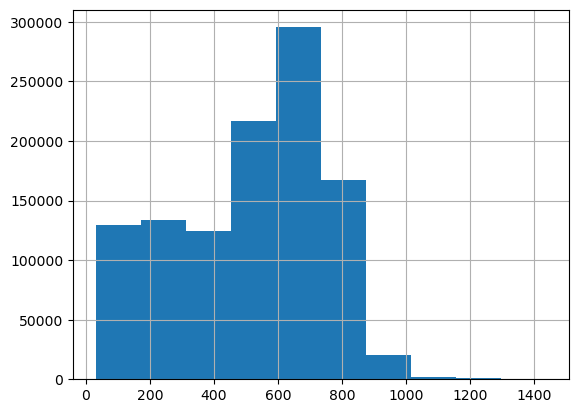

In [21]:
df['time_to_under'].hist()

In [ ]:
Создадим функцию для приведения таблицы к единому виду:

In [8]:
def time_preprocess_r(df):
    df['day'] = df.pass_dttm.dt.dayofweek #день недели
    df['hour'] = df.pass_dttm.dt.hour # час в формате 24
    df['workday'] = df['day'].apply(lambda x: 0 if x == 5 or x == 6 else 1)
    df = df.drop(columns=['pass_dttm','entrance_nm','station_nm','line_nm','ticket_type_nm','label'])
    return df

In [ ]:
Далее предскажем время следующей валидации с помощью OLS

In [9]:
df.pass_dttm = pd.to_datetime(df.pass_dttm)
df = sm.add_constant(df)
x_regress_train, x_regress_test, y_regress_train, y_regress_test = train_test_split(df.drop(columns=['time_to_under']), df[['time_to_under']], test_size=0.3)
x_regress_train = time_preprocess_r(x_regress_train)
x_regress_test = time_preprocess_r(x_regress_test)

model_regression = sm.OLS(y_regress_train,x_regress_train)
model_regression=model_regression.fit()
forecast_regression= model_regression.predict(x_regress_test)

Далее решим задачу классификации:

In [11]:
def time_preprocess_c(df):
    df['day'] = df.pass_dttm.dt.dayofweek #день недели
    df['hour'] = df.pass_dttm.dt.hour # час в формате 24
    df['workday'] = df['day'].apply(lambda x: 0 if x == 5 or x == 6 else 1)

   # df['name_workday'] = df['day'].apply(lambda x : 'holiday' if x == 5 or x ==6  else 'work')

    df = df.drop(columns=['pass_dttm','day','hour'])
    return df

In [ ]:
Возьмем для обучения 10000 строк, создадим таблицу из этих значений, преобразуем к специальному виду и предскажем для 250 строк.

In [17]:
df.pass_dttm = pd.to_datetime(df.pass_dttm)

x_class_train = df.drop(columns=['label'])[:10000]
y_class_train = df[['label']][:10000]


test_class = df.loc[df.ticket_type_nm.isin(x_class_train.ticket_type_nm)&
                    df.entrance_nm.isin(x_class_train.entrance_nm) &
                    df.station_nm.isin(x_class_train.station_nm) &
                    df.line_nm.isin(x_class_train.line_nm) ]

x_class_test = test_class.drop(columns=['label'])[-250:]
y_class_test = test_class[['label']][-250:]

x_class_train = time_preprocess_c(x_class_train)
x_class_test = time_preprocess_c(x_class_test)


model_class = CatBoostClassifier(iterations = 10)
model_class.fit(x_class_train,y_class_train, cat_features=['workday','ticket_type_nm','entrance_nm','station_nm','line_nm'])
forecast_class= model_class.predict(x_class_test)


Learning rate set to 0.5
0:	learn: 5.3375006	total: 1m 25s	remaining: 12m 45s
1:	learn: 5.1560095	total: 2m 48s	remaining: 11m 12s
2:	learn: 5.1692189	total: 4m 11s	remaining: 9m 47s
3:	learn: 4.9770172	total: 5m 35s	remaining: 8m 22s
4:	learn: 4.8987697	total: 6m 57s	remaining: 6m 57s
5:	learn: 4.8018424	total: 8m 22s	remaining: 5m 35s
6:	learn: 4.7751913	total: 9m 49s	remaining: 4m 12s
7:	learn: 4.7359671	total: 11m 14s	remaining: 2m 48s
8:	learn: 4.6597006	total: 12m 38s	remaining: 1m 24s
9:	learn: 4.6385967	total: 14m 9s	remaining: 0us


Расчитаем необходимые метрики

In [18]:
from sklearn.metrics import r2_score, recall_score, mean_absolute_percentage_error
def result(actual_class, forecast_class, actual_regress, forecast_regress):
    print(r2_score(actual_regress, forecast_regress))
    print(recall_score(actual_class, forecast_class, average='micro'))
    return 0.5 * r2_score(actual_regress, forecast_regress) + 0.5 * recall_score(actual_class, forecast_class, average='micro')


In [19]:
print('result: ', result(y_class_test, forecast_class, y_regress_test, forecast_regression))

0.46381549846365655
0.012
result:  0.23790774923182828
